In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

#id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}



In [3]:

p3 = '/home/wtownle1/dimensionality_powerlaw/'
import sys
sys.path.append(p3)
from activation_models.AtlasNet.model_2L_eig import EngineeredModel2L_Eig
from activation_models.AtlasNet.model_2L_SVD import EngineeredModel2L_SVD
from activation_models.AtlasNet.model_2L import EngineeredModel2L
from torch import nn

weight_dict = {}
seed = 0
#alphas = [-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
#alphas = [-0.6, -1, -1.4]
alphas = [-1]
#vscales = [1, 10, 100]
methods = ['None', 'Eig', 'SVD']
for method in methods:
    if method == 'None':
        model = EngineeredModel2L(filters_2=1000, k_size=9, seed=0).Build()
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                weight_dict[method] = m.weight
    else:
        for a in alphas:
            if method == 'SVD':
                model = EngineeredModel2L_SVD(filters_2=1000, k_size=9, exponent=a, seed=seed).Build()
                for m in model.modules():
                    if isinstance(m, nn.Conv2d):
                        key = method + f'_{a}'
                        weight_dict[key] = m.weight
                
            elif method == 'Eig':
                #for v in vscales:
                    model = EngineeredModel2L_Eig(filters_2=1000, k_size=9, exponent=a, var_scale=1, seed=seed).Build()
                    for m in model.modules():
                        if isinstance(m, nn.Conv2d):
                            key = method + f'_{a}_{1}'
                            weight_dict[key] = m.weight

            

1.0552014871598294
1.00770288531585
-1
1.0546491966319818
0.9991878970214365


In [ ]:
p3 = '/home/wtownle1/dimensionality_powerlaw/'
import sys
sys.path.append(p3)
from activation_models.AtlasNet.model_2L_eig import EngineeredModel2L_Eig
from activation_models.AtlasNet.model_2L_SVD import EngineeredModel2L_SVD
from activation_models.AtlasNet.model_2L import EngineeredModel2L
from torch import nn

alphas = [-0.2, -0.6, -1.0, -1.4, -2, -3]
standard_devs = [0.1, 1.0]
var_scales = [0.1, 1, 10]
scaled = [True, False]
methods = ['Eig', 'SVD', 'None']

for method in methods:
    for a in alphas:
        if method == 'Eig':
            for v in var_scales:
                for sd in standard_devs:
                    model = EngineeredModel2L_Eig(filters_2=1000, k_size=9, exponent=a, var_scale=v, dist_stdev=sd, seed=seed).Build()
                    for m in model.modules():
                        if isinstance(m, nn.Conv2d):
                            key = method + f'|a_{a}|v_{v}|stdev_{sd}'
                            weight_dict[key] = m.weight
        elif method == 'SVD':
            for s in scaled:
                model = EngineeredModel2L_SVD(filters_2=1000, k_size=9, exponent=a, scaled=s, seed=seed).Build()
                for m in model.modules():
                    if isinstance(m, nn.Conv2d):
                        key = method + f'|scaled_{s}'
                        weight_dict[key] = m.weight
        else:
            model = EngineeredModel2L(filters_2=1000, k_size=9, seed=0).Build()
            for m in model.modules():
                if isinstance(m, nn.Conv2d):
                    key = method
                    weight_dict[key] = m.weight
                
                

In [4]:
print(weight_dict.keys())

dict_keys(['None', 'Eig_-1_1', 'SVD_-1'])


In [5]:
from sklearn.decomposition import PCA
from model_tools.activations.core import flatten
import numpy as np
from scipy import stats

eigenspectrum = {}
eigenspectrum_zscore = {}
for init, weights in weight_dict.items():
    weights = weights.numpy(force=True)
    weights = flatten(weights)
    weights2 = stats.zscore(weights, axis=0)
    pca = PCA(random_state=0)
    pca.fit(weights)
    eigenspectrum[init] = pca.explained_variance_
    pca2 = PCA(random_state=0)
    pca2.fit(weights2)
    eigenspectrum_zscore[init] = pca2.explained_variance_


In [24]:
for init, weights in weight_dict.items():
    if init == 'Eig_-1_1':
        weights = weights.numpy(force=True)
        weights = flatten(weights)
        pre_weights = weights
        weights2 = stats.zscore(weights, axis=0)
        zscore_weights = weights2
        pca = PCA(random_state=0)
        pca.fit(weights)
        pre_variance = pca.explained_variance_
        pre_vectors = pca.components_
        transformed_weights = pca.transform(weights)
        pca2 = PCA(random_state=0)
        pca2.fit(weights2)
        zscore_variance = pca2.explained_variance_
        zscore_vectors = pca2.components_
        zscore_transformed = pca2.transform(weights2)
        
    
pca3 = PCA(random_state=0)
pca3.fit(transformed_weights)
post_variance = pca3.explained_variance_
post_vectors = pca3.components_

pca4 = PCA(random_state=0)
pca4.fit(zscore_transformed)
post_zscore_variance = pca4.explained_variance_
post_zscore_vectors = pca4.components_

In [25]:
#print(pre_weights.shape)
#print(transformed.shape)
#print(pre_vectors.shape)
#print(post_vectors.shape)

print(np.allclose(zscore_variance, post_zscore_variance))


True


In [4]:
def effective_dimensionalities(eigenspectrum):
    effdims = {init: eigspec.sum() ** 2 / (eigspec ** 2).sum()
                for init, eigspec in eigenspectrum.items()}
    return effdims

def powerlaw_exponent(eigenspectrum):
    alpha_calculated = {}
    for init, eigspec in eigenspectrum.items():
        start = 0
        end = np.log10(len(eigspec))
        eignum = np.logspace(start, end, num=50).round().astype(int)
        eigspec = eigspec[eignum - 1]
        logeignum = np.log10(eignum)
        logeigspec = np.log10(eigspec)
        linear_fit = LinearRegression().fit(logeignum.reshape(-1, 1), logeigspec)
        alpha_calculated[init] = -linear_fit.coef_.item()
    return alpha_calculated


def as_df(eigenspectrum):
    df = pd.DataFrame()
    for init, rdm in eigenspectrum.items():
        layer_df = pd.DataFrame({'n': range(1, len(rdm) + 1), 'variance': rdm})
        layer_df = layer_df.assign(init=init)
        df = df.append(layer_df)
    return df

def metrics_as_df(eigenspectrum):
    effdims = effective_dimensionalities(eigenspectrum)
    calculated_alpha = powerlaw_exponent(eigenspectrum)
    df = pd.DataFrame()
    for init in eigenspectrum:
        df = df.append({'init': init,
                        'effective dimensionality': effdims[init],
                        'calculated_alpha': calculated_alpha[init]},
                        ignore_index=True)
    return df


In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression

eigspec_df = pd.DataFrame()
eigmetrics_df = pd.DataFrame()

eigspec_df = eigspec_df.append(as_df(eigenspectrum))
eigmetrics_df = eigmetrics_df.append(metrics_as_df(eigenspectrum))

#eigspec_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightspectra_AtlasNet_Eig|seed:0.csv', index=False)
#eigmetrics_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightmetrics_AtlasNet_Eig|seed:0.csv', index=False)

zscorespec_df = pd.DataFrame()
zscoremetrics_df = pd.DataFrame()

zscorespec_df = zscorespec_df.append(as_df(eigenspectrum_zscore))
zscoremetrics_df = zscoremetrics_df.append(metrics_as_df(eigenspectrum_zscore))



In [43]:
print(zscoremetrics_df)
print(eigmetrics_df)

            init  effective dimensionality  calculated_alpha
0           None                660.159583          0.714173
1     Eig_-0.6_1                660.740378          0.716414
2    Eig_-0.6_10                660.740322          0.718646
3   Eig_-0.6_100                660.740434          0.717156
4       Eig_-1_1                660.740378          0.717082
5      Eig_-1_10                660.740431          0.717745
6     Eig_-1_100                660.740461          0.713287
7     Eig_-1.4_1                660.740322          0.719634
8    Eig_-1.4_10                660.740378          0.715597
9   Eig_-1.4_100                660.740375          0.717233
10      SVD_-0.6                337.172805          1.035627
11        SVD_-1                 41.951473          1.450816
12      SVD_-1.4                 10.429892          1.798332
            init  effective dimensionality  calculated_alpha
0           None                659.963665          0.700317
1     Eig_-0.6_1        

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.


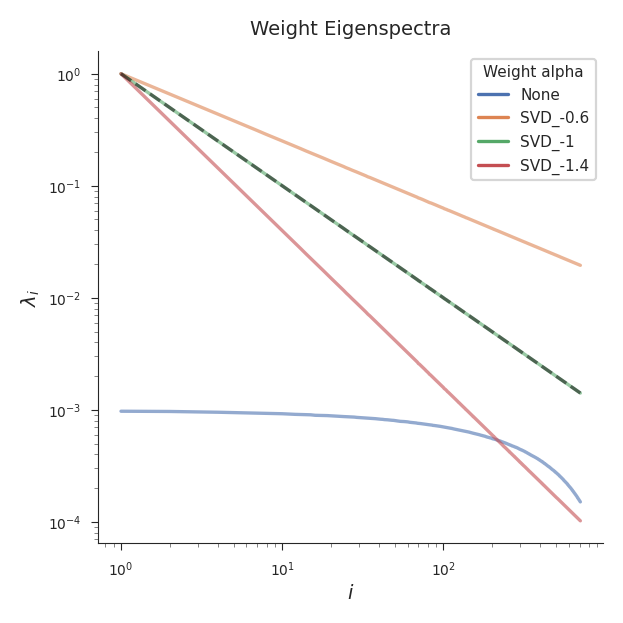

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


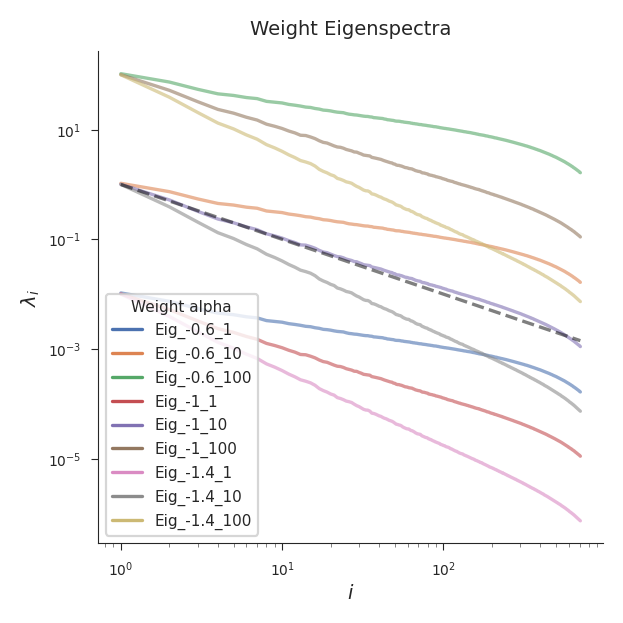

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.


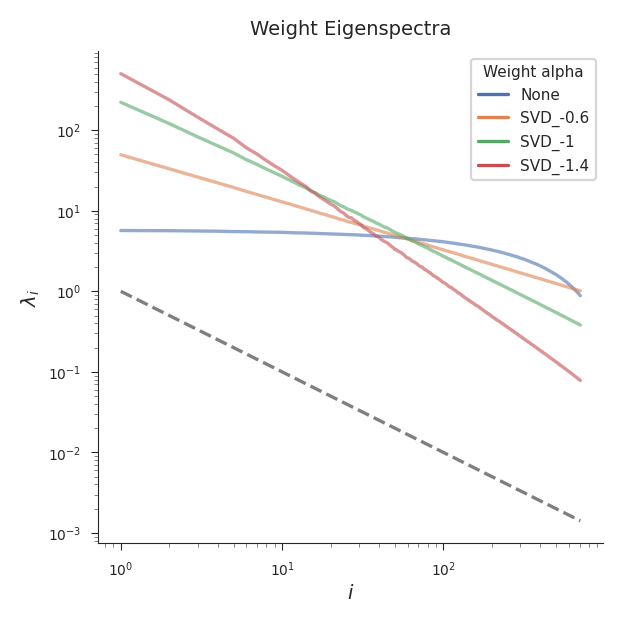

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


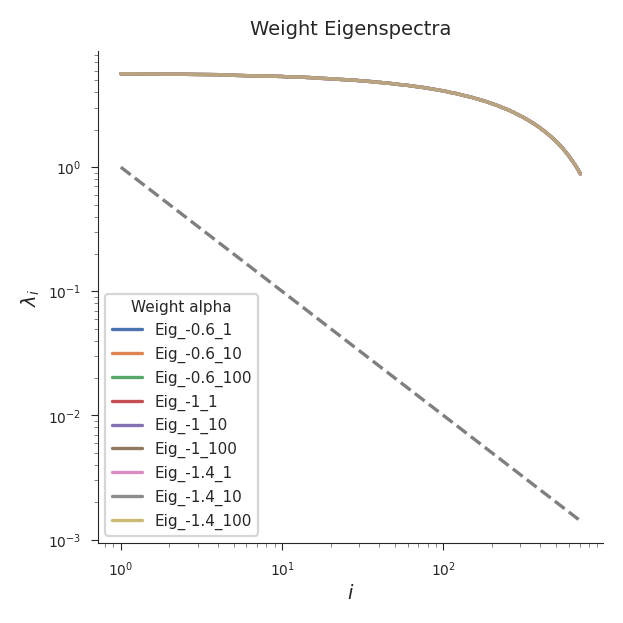

In [44]:

#metrics = pd.read_csv(f'../../results/weight_spectrum/weightmetrics_AtlasNet_Eig|seed:0.csv')
#spectra = pd.read_csv(f'../../results/weight_spectrum/weightspectra_AtlasNet_Eig|seed:0.csv')

id_columns = ['init']
#data = pd.merge(spectra, metrics, on=id_columns)
data = pd.merge(eigspec_df, eigmetrics_df, on=id_columns)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

#__Not scaled SVD + Standard__
data_other = data[ (data['init'].str.split('_').str[0] != 'Eig')]
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_other, x='n', y='variance', hue='init',
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#_Not scaled Eig_
data_eig = data[ (data['init'].str.split('_').str[0] == 'Eig')]
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_eig, x='n', y='variance', hue='init', 
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#---------------
#zscored
id_columns = ['init']
#data = pd.merge(spectra, metrics, on=id_columns)
data = pd.merge(zscorespec_df, zscoremetrics_df, on=id_columns)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

#__Not scaled SVD + Standard__
data_other = data[ (data['init'].str.split('_').str[0] != 'Eig')]
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_other, x='n', y='variance', hue='init',
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#_Not scaled Eig_
data_eig = data[ (data['init'].str.split('_').str[0] == 'Eig')]
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_eig, x='n', y='variance', hue='init', 
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()




#keep = 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2
#data = data[( data['specified_alpha'] != -0.2)]...
#fig, ax = plt.subplots(figsize=(3, 3))
#sns.lineplot(data=data, x='n', y='scaled_variance', hue='specified_alpha',
#             units='specified_alpha', alpha=1, estimator=None,
#             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
#ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
#ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Eigenspectra')
##ax.set_ylim(bottom=10**(-9), top=10**4)
#ax.get_legend().remove()
##**ylimits?
#plt.show()

In [21]:
weight_list = []
for init, weights in weight_dict.items():
    if init != 'None':
        if init.split('_')[1] == '-1.4':
            print(init)
            weights = weights.numpy(force=True)
            weights = weights.flatten()
            #flatten(weights)
            weight_list.append(weights)



Eig_-1.4_1
Eig_-1.4_10
Eig_-1.4_100
SVD_-1.4


In [34]:
#weight_list = []
for init, weights in weight_dict.items():
    print(init)
    weights = weights.numpy(force=True)
    weights = weights.flatten()
    #flatten(weights)
    print(np.std(weights))


None
0.013089129
Eig_-0.6_1
0.015988022
Eig_-0.6_10
0.15988024
Eig_-0.6_100
1.5988023
Eig_-1_1
0.0064578783
Eig_-1_10
0.06457877
Eig_-1_100
0.6457878
Eig_-1.4_1
0.003903692
Eig_-1.4_10
0.03903693
Eig_-1.4_100
0.39036933
SVD_-0.6
0.13914771
SVD_-1
0.062021773
SVD_-1.4
0.038921233


In [1]:
#re-importing with a different normal distrbution standard deviation inside 2L_eig (1 instead of 0.1)
# - and turning SVD back to scaled

p = '/home/wtownle1/dimensionality_powerlaw/'
import sys
sys.path.append(p)
from activation_models.AtlasNet.model_2L_eig import EngineeredModel2L_Eig
from activation_models.AtlasNet.model_2L_SVD import EngineeredModel2L_SVD
from torch import nn

methods = ['EigN', 'SVDscaled']
alphas = [-0.6, -1, -1.4]
v_scales = [0.1, 1, 10]
weight_dict = {}
seed = 0
for method in methods:
    for a in alphas:
        if method == 'SVDscaled':
            model = EngineeredModel2L_SVD(filters_2=1000, k_size=9, exponent=a, seed=seed).Build()
            for m in model.modules():
                if isinstance(m, nn.Conv2d):
                    key = method + f'_{a}'
                    weight_dict[key] = m.weight
            
        elif method == 'EigN':
            for v in v_scales:
                model = EngineeredModel2L_Eig(filters_2=1000, k_size=9, exponent=a, var_scale=v, seed=seed).Build()
                for m in model.modules():
                    if isinstance(m, nn.Conv2d):
                        key = method + f'_{a}_{v}'
                        weight_dict[key] = m.weight
            




0.6400838939930912
0.010508162771130496
0.6399937884948463
1.0508162772362988
0.6398904246411873
105.08162783641018
1.0552014868159694
0.010077028850817148
1.0552014871598294
1.00770288531585
1.0552014869313626
100.77028863149222
1.479745406977441
0.010028993692880885
1.4804030908639425
1.0028993695052488
1.4803378827142286
100.28993705284073
-0.6
0.6594568165373751
0.5433611647786072
-1
1.054649196534177
1.3711710104667616
-1.4
1.4573364188616609
2.197765509961114


In [2]:
from sklearn.decomposition import PCA
from model_tools.activations.core import flatten
import numpy as np
from scipy import stats

eigenspectrum = {}
eigenspectrum_zscore = {}
for init, weights in weight_dict.items():
    weights = weights.numpy(force=True)
    weights = flatten(weights)
    weights2 = stats.zscore(weights, axis=0)
    pca = PCA(random_state=0)
    pca.fit(weights)
    eigenspectrum[init] = pca.explained_variance_
    pca2 = PCA(random_state=0)
    pca2.fit(weights2)
    eigenspectrum_zscore[init] = pca2.explained_variance_



In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression

eigspec2_df = pd.DataFrame()
eigmetrics2_df = pd.DataFrame()

eigspec2_df = eigspec2_df.append(as_df(eigenspectrum))
eigmetrics2_df = eigmetrics2_df.append(metrics_as_df(eigenspectrum))

#eigspec_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightspectra_AtlasNet_Eig|seed:0.csv', index=False)
#eigmetrics_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightmetrics_AtlasNet_Eig|seed:0.csv', index=False)

zscorespec2_df = pd.DataFrame()
zscoremetrics2_df = pd.DataFrame()

zscorespec2_df = zscorespec2_df.append(as_df(eigenspectrum_zscore))
zscoremetrics2_df = zscoremetrics2_df.append(metrics_as_df(eigenspectrum_zscore))

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.


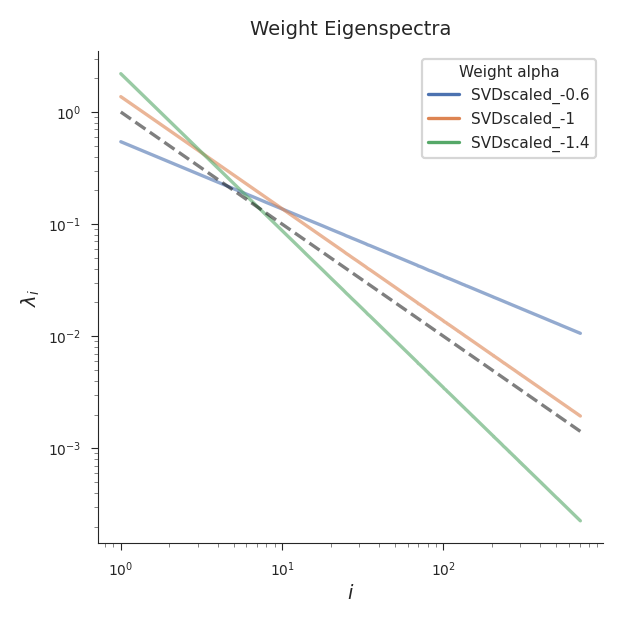

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


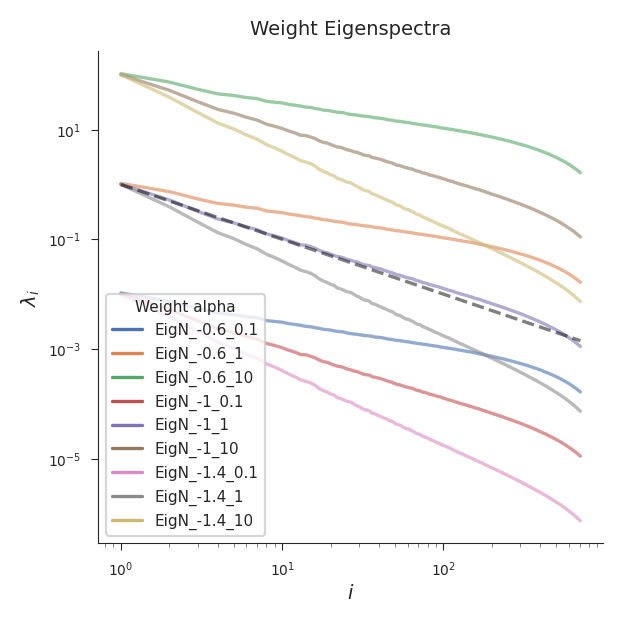

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.


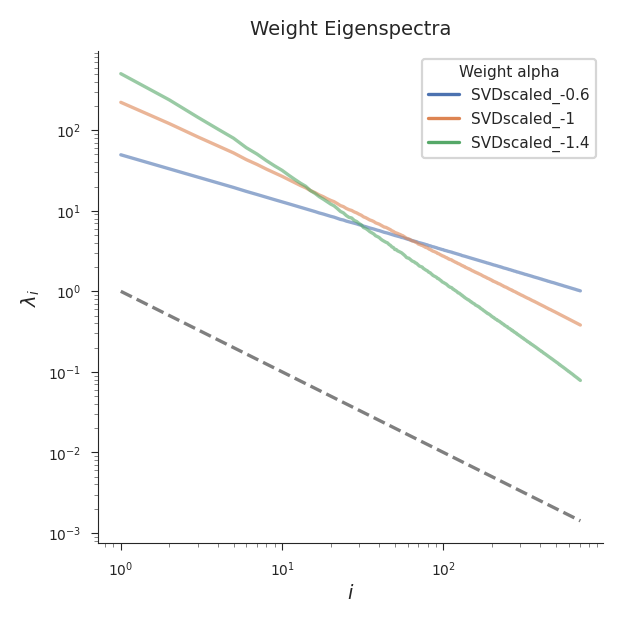

/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.


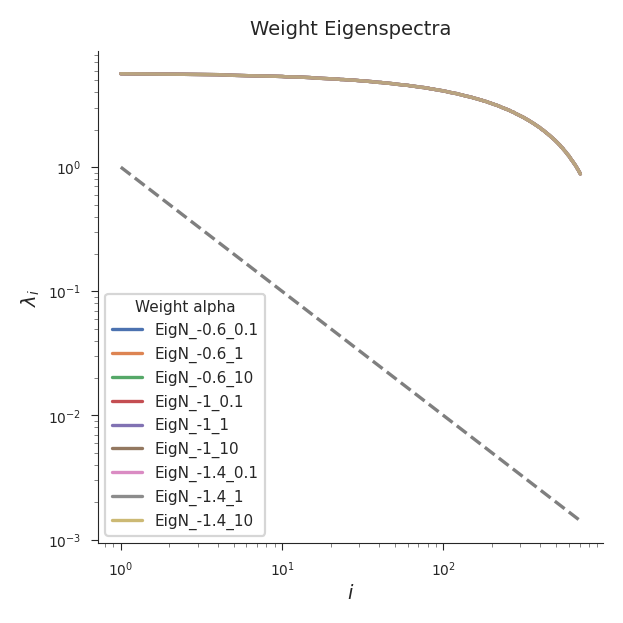

In [8]:
id_columns = ['init']
#data = pd.merge(spectra, metrics, on=id_columns)
data = pd.merge(eigspec2_df, eigmetrics2_df, on=id_columns)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

#__Not scaled SVD__
data_other = data[ (data['init'].str.split('_').str[0] != 'EigN')]

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_other, x='n', y='variance', hue='init',
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#_Not scaled Eig_
data_eig = data[ (data['init'].str.split('_').str[0] == 'EigN')]
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_eig, x='n', y='variance', hue='init', 
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#---------------
#zscored
id_columns = ['init']
#data = pd.merge(spectra, metrics, on=id_columns)
data = pd.merge(zscorespec2_df, zscoremetrics2_df, on=id_columns)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

#__Not scaled SVD__
data_other = data[ (data['init'].str.split('_').str[0] != 'EigN')]

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_other, x='n', y='variance', hue='init',
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#_Not scaled Eig_
data_eig = data[ (data['init'].str.split('_').str[0] == 'EigN')]

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data_eig, x='n', y='variance', hue='init', 
             units='init', alpha=0.6, estimator=None,
             #palette=sns.color_palette('vlag', as_cmap=True), 
             palette=sns.color_palette(),
             ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'$\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()

In [6]:

for init, weights in weight_dict.items():
    print(init)
    weights = weights.numpy(force=True)
    weights = weights.flatten()
    #flatten(weights)
    print(np.std(weights))

EigN_-0.6_0.1
0.015988022
EigN_-0.6_1
0.15988024
EigN_-0.6_10
1.5988023
EigN_-1_0.1
0.0064578783
EigN_-1_1
0.06457877
EigN_-1_10
0.6457878
EigN_-1.4_0.1
0.003903692
EigN_-1.4_1
0.03903693
EigN_-1.4_10
0.39036933
SVDscaled_-0.6
0.10261038
SVDscaled_-1
0.07265514
SVDscaled_-1.4
0.057723735


In [ ]:
from torchvision.models import alexnet
from torch import nn

weight_string = 'IMAGENET1K_V1'
model = alexnet(weights=weight_string)

weight_dict = {}
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        weight_dict[name] = module.weight


In [ ]:
from sklearn.decomposition import PCA
from model_tools.activations.core import flatten
#import numpy as np

eigenspectrum = {}
for layer, weights in weight_dict.items():
    weights = weights.numpy(force=True)
    weights = flatten(weights)
    pca = PCA(random_state=0)
    pca.fit(weights)
    eigenspectrum[layer] = pca.explained_variance_


In [ ]:
def effective_dimensionalities(eigenspectrum):
    effdims = {layer: eigspec.sum() ** 2 / (eigspec ** 2).sum()
                for layer, eigspec in eigenspectrum.items()}
    return effdims

def powerlaw_exponent(eigenspectrum):
    alpha_calculated = {}
    for layer, eigspec in eigenspectrum.items():
        start = 0
        end = np.log10(len(eigspec))
        eignum = np.logspace(start, end, num=50).round().astype(int)
        eigspec = eigspec[eignum - 1]
        logeignum = np.log10(eignum)
        logeigspec = np.log10(eigspec)
        linear_fit = LinearRegression().fit(logeignum.reshape(-1, 1), logeigspec)
        alpha_calculated[layer] = -linear_fit.coef_.item()
    return alpha_calculated


def as_df(eigenspectrum):
    df = pd.DataFrame()
    for layer, rdm in eigenspectrum.items():
        layer_df = pd.DataFrame({'n': range(1, len(rdm) + 1), 'variance': rdm})
        layer_df = layer_df.assign(layer=layer)
        df = df.append(layer_df)
    return df

def metrics_as_df(eigenspectrum):
    effdims = effective_dimensionalities(eigenspectrum)
    calculated_alpha = powerlaw_exponent(eigenspectrum)
    df = pd.DataFrame()
    for layer in eigenspectrum:
        df = df.append({'layer': layer,
                        'effective dimensionality': effdims[layer],
                        'alpha': calculated_alpha[layer]},
                        ignore_index=True)
    return df


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

eigspec_df = pd.DataFrame()
eigmetrics_df = pd.DataFrame()

eigspec_df = eigspec_df.append(as_df(eigenspectrum))
eigmetrics_df = eigmetrics_df.append(metrics_as_df(eigenspectrum))
#print(eigmetrics_df)

eigspec_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightspectra_AlexNet|weights:{weight_string}.csv', index=False)
eigmetrics_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightmetrics_AlexNet|weights:{weight_string}.csv', index=False)



In [ ]:
#metrics = pd.read_csv(f'../../results/weight_spectrum/weightmetrics_AlexNet|weights:IMAGENET1K_V1.csv')
#spectra = pd.read_csv(f'../../results/weight_spectrum/weightspectra_AlexNet|weights:IMAGENET1K_V1.csv')

id_columns = ['layer']
data = pd.merge(eigspec_df, eigmetrics_df, on=id_columns)
#data['id'] = 'AtlasNet|alpha='

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='layer', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='AlexNet Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'$\log{(ED)}$')
plt.show()


#Relative depth
model_depth = 13
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth', legend='full',
             units='layer', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='AlexNet Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Relative Depth')
plt.show()

